# Forcasting bank clients' churn

## Content <a id='content'></a>
1. [Goal](#goal)
1. [Tasks](#tasks)
1. [Data](#data) 
3. [Preparation for analysis](#prepare)
1. [Data analysis](#analysis)
1. [Choosing Customer churn prediction model](#choosing)
  - [Default results for Random Forest and Logistic Regression](#default)
  - [Working with unbalanced classes](#optimization)
     - [Hyper-parameter class_weight='balanced'](#balanced)
     - [Upsampling](#upsampling)
     - [Downsampling](#downsampling)
1. [Optimal model on the test sample](#test)
1. [Summary](#summary)

## Goal <a id="goal"></a>

We have historical data with churn results and need to forcast customers' churn in the nearest future. 

## Tasks <a id="tasks"></a>

1. Prepare data for analysis
1. Look at the features distribution
1. Look at the models' results with the default parameters
1. Use several ways to balance the classes: balancing them in hyper-parameters, upsampling and downsampling
1. Test the best model 

## Data <a id="data"></a>

Source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Preparation for analysis <a id="prepare"></a>

[Back to content](#content)

Let's import libraries and have a look at the data-set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Churn.csv')
display(df.head())
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


We have data for 10,000 clients. 11 features, the target of which is "Exited", their churn. `RowNumber`, `CustomerID`, `Surname` are not features.

There are gaps in the Tenure column, i.e. the amount of real estate the client has.

## Data analysis <a id="analysis"></a>

[Back to content](#content)

Let's have a look at the gaps. 

In [3]:
display(df['Tenure'].value_counts())
df['Tenure'].mean()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

4.997690023099769

We can assume that customers without this data do not have real estate. So let's fill in the gaps with zeros.

In [4]:
display(df['Tenure'].isna().mean())
df['Tenure']=df.fillna(0)
df['Tenure'].isna().mean()

0.0909

0.0

We have substituted 9% of the set. 

Let's see whether there are any features that are too correlated with each other.

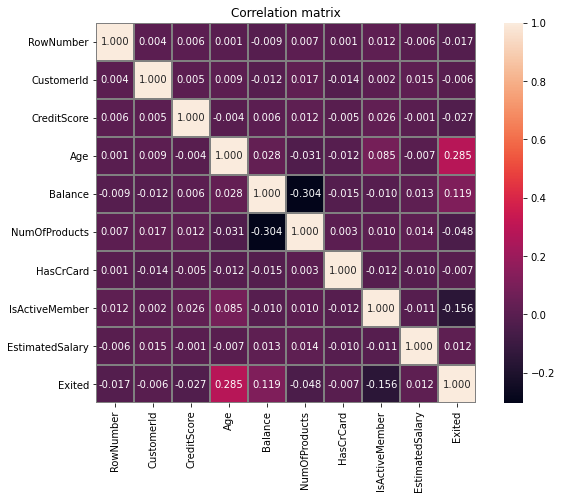

In [5]:
cm = df.corr()
plt.figure(figsize=(10, 7))
plt.title('Correlation matrix')
sns.heatmap(cm, annot=True, square=True, fmt='.3f', linewidths=1, linecolor='gray') 
plt.show()

There are no features strongly correlated with each other (the threshold would be 0.7.). The churn is most noticeably influenced by the age and activity of the client. 

Let's look at the distribution of numerical features.

In [6]:
df_num=df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary', 'Exited']]
df_num.head()

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary,Exited
0,619,42,1,1,0.00,101348.88,1
1,608,41,2,1,83807.86,112542.58,0
2,502,42,3,3,159660.80,113931.57,1
3,699,39,4,2,0.00,93826.63,0
4,850,43,5,1,125510.82,79084.10,0


In [7]:
display(df_num.groupby('Exited').mean())
df_num.groupby('Exited').median()

,CreditScore,Age,NumOfProducts,Balance,EstimatedSalary
Exited,,,,,
0,651.853196,37.408389,1.544267,72745.296779,99738.391772
1,645.351497,44.837997,1.475209,91108.539337,101465.677531


,CreditScore,Age,NumOfProducts,Balance,EstimatedSalary
Exited,,,,,
0,653,36,2,92072.68,99645.04
1,646,45,1,109349.29,102460.84


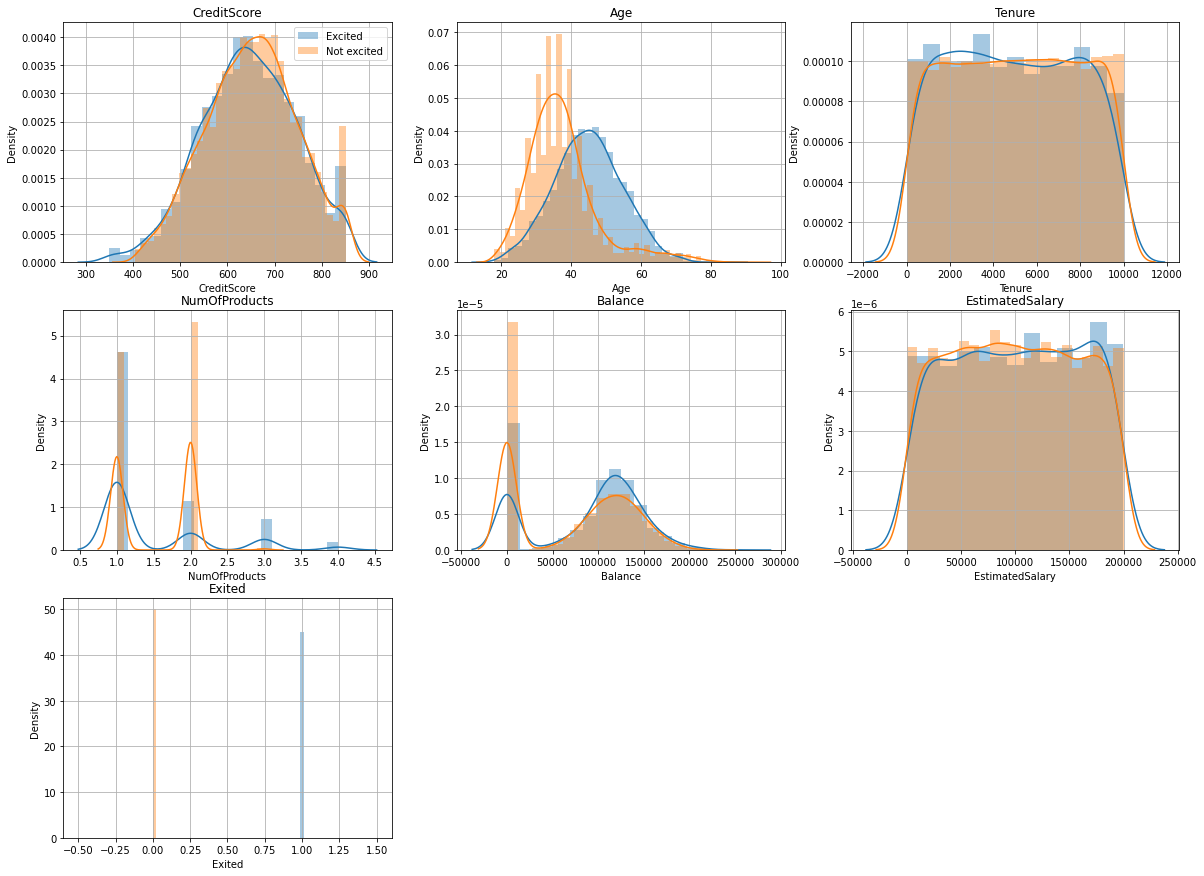

In [8]:
plt.subplots(figsize=(20,15))
num_cols=3
num_rows=len(df_num.columns.values)//num_cols + 1
for i, col in enumerate(df_num.columns.values):
    sns.distplot(df_num.query('Exited==1')[col], label ='Excited', ax=plt.subplot(num_rows,num_cols, i+1))
    sns.distplot(df_num.query('Exited==0')[col], label ='Not excited')
    plt.title(col)
    plt.grid()
    if i ==0: plt.legend()

- The credit score is higher for those who stay, the difference in peak values is 10 points.
- We see that the departed are older, the peak frequency is 45 years old, for the remaining - 37.
- The balance on the card of the churn customer is greater than that of the remaining.
- Among the remaining customers, two products are more often used than among those who left.

Now let's look at the distribution of categorical features.

In [9]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,1,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,2,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,3,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,4,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,5,125510.82,1,1,1,79084.10,0


In [10]:
df_cat=df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]
df_cat.head()

,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,France,Female,1,1,1
1,Spain,Female,0,1,0
2,France,Female,1,0,1
3,France,Female,0,0,0
4,Spain,Female,1,1,0


In [11]:
display(df_cat.groupby('Exited').mean())

,HasCrCard,IsActiveMember
Exited,,
0,0.707146,0.554565
1,0.699067,0.360825


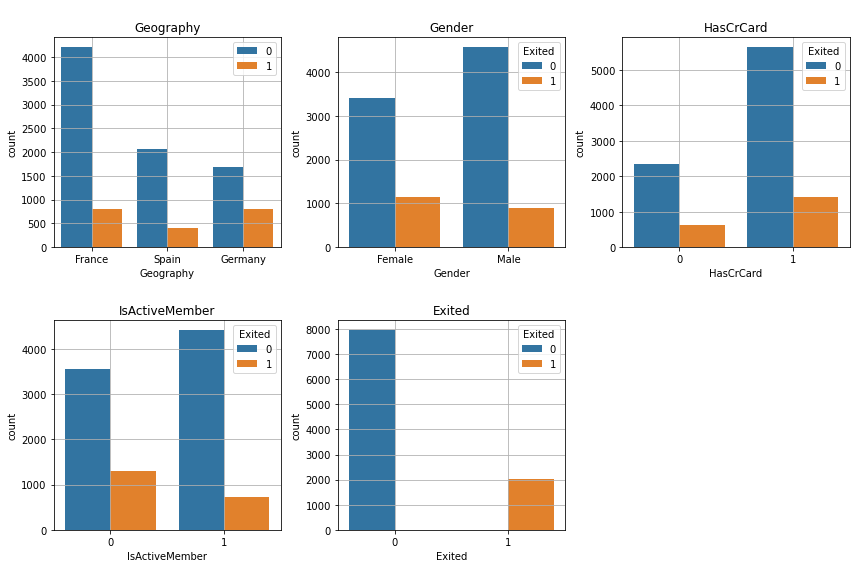

In [12]:
plt.subplots(figsize = (12, 8))
num_cols = 3
num_rows = 2

for i, col in enumerate(df_cat.columns.values):
    sns.countplot(x = df[col], hue='Exited', data=df, ax = plt.subplot(num_rows, num_cols, i+1))
    plt.title('\n' + col)
    plt.tight_layout()
    plt.grid()
    if i == 0: plt.legend()

- Among customers from Germany, the percentage of churn customers is higher than in France and Spain.
- There is a lower outflow rate among credit card users.
- The percentage of those who left is higher among women.
- The percentage of churn is higher among inactive users.

Two non-numeric attributes in the table are categorical, 'Geography' and 'Gender'.

In [13]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

There are only three countries. We'll recode the columns with categorical values in dummies, so that we can then use them for training models.

In [14]:
categ=['Geography','Gender']
df_ohe=df.copy()
for i in categ:
  df_ohe = pd.concat([df_ohe, df_ohe[i].str.get_dummies()], axis = 1).drop(i, 1)
df_ohe.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,1,15634602,Hargrave,619,42,1,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,2,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,3,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,4,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,5,125510.82,1,1,1,79084.10,0,0,0,1,1,0


And now we'll split the data-set. 

Let's define the features for trainig and a target feature.

In [15]:
target = df_ohe['Exited']
features = df_ohe.drop(['Surname','Exited', 'RowNumber','CustomerId'], axis=1) #let's remove the non-features from the set

Let's look at the churn percentage for all set data.

In [16]:
df_ohe['Exited'].value_counts(0)/len(df_ohe)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

20% of customers are in the outflow. While splitting on a set, we need to make sure that the positive class is distributed evenly across all the samples, so we'll add `stratify=target` parameter. 

In [17]:
features_train, features_test, target_train, target_test  = train_test_split(features, target, test_size=0.2, random_state=1, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=1, stratify=target_train)
display(len(features_train))
display(len(features_test))
display(len(features_valid))

6000

2000

2000

Let's standardize the numeric attributes.

In [18]:
numeric=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
4472,0.091585,-1.519034,-0.193940,1.447084,0.786577,0,0,-0.173839,0,1,0,1,0
4034,-0.516304,0.279984,-0.346159,0.340252,-0.915356,1,1,1.713093,0,0,1,1,0
1454,-1.340560,-0.477497,-1.242794,-0.075495,-0.915356,1,1,-1.392789,0,0,1,1,0
9099,0.895235,-0.950923,1.414094,-1.205076,0.786577,1,1,1.212999,1,0,0,0,1
2489,0.647958,-1.045608,-0.883097,0.754843,-0.915356,1,1,-0.580512,1,0,0,0,1


Our samples are ready for research: the correlation between the features is checked, the gaps are filled in, the categorical values are converted by the OHE technique, and the numerical features are scaled. We will use a training sample to train the model, a validation sample to select the best model and hyper-parameters, and a test sample to test the selected optimal model.

## Choosing Customer churn prediction model <a id="choosing"></a> 

[Back to content](#content)

### Default results for Random Forest and Logistic Regression  <a id="default"></a> 

To define a class with an outflow label, we will set a random forest learning algorithm and a logistic regressionone with standard hyper-parameters and without changing the amount of data in the classes. Let's look at the starting point for improving the models.

In [19]:
rf_model_d=RandomForestClassifier(random_state=0)
lr_model_d=LogisticRegression(solver='liblinear', random_state=0)

Let's train the model on the training samples.

In [20]:
lr_model_d.fit(features_train, target_train)

LogisticRegression(random_state=0, solver='liblinear')

In [21]:
rf_model_d.fit(features_train, target_train)

RandomForestClassifier(random_state=0)

We will make predictions on the validation samples.

In [22]:
lr_predictions_valid_d = lr_model_d.predict(features_valid)
rf_predictions_valid_d = rf_model_d.predict(features_valid) 

Let's evaluate the result of two models using the accuracy, precision, recall, and f1 metrics on the validation sample.

In [23]:
print('Logistic regression metrics')
print('Accuracy: {:.2f}'.format(accuracy_score(target_valid,lr_predictions_valid_d))) 
print('Precision: {:.2f}'.format(precision_score(target_valid, lr_predictions_valid_d)))
print('Recall: {:.2f}'.format(recall_score(target_valid, lr_predictions_valid_d)))
print('F1: {:.2f}'.format(f1_score(target_valid, lr_predictions_valid_d)))
print()
print('Random forest metrics')
print('Accuracy: {:.2f}'.format(accuracy_score(target_valid,rf_predictions_valid_d))) 
print('Precision: {:.2f}'.format(precision_score(target_valid, rf_predictions_valid_d)))
print('Recall: {:.2f}'.format(recall_score(target_valid, rf_predictions_valid_d)))
print('F1: {:.2f}'.format(f1_score(target_valid, rf_predictions_valid_d)))

Logistic regression metrics
Accuracy: 0.81
Precision: 0.62
Recall: 0.20
F1: 0.30

Random forest metrics
Accuracy: 0.85
Precision: 0.74
Recall: 0.41
F1: 0.53


In [24]:
probabilities_valid_d = lr_model_d.predict_proba(features_valid)
probabilities_one_valid_d = probabilities_valid_d[:, 1]
auc_roc_d=roc_auc_score(target_valid, probabilities_one_valid_d)
print(auc_roc_d)

0.774422048970342


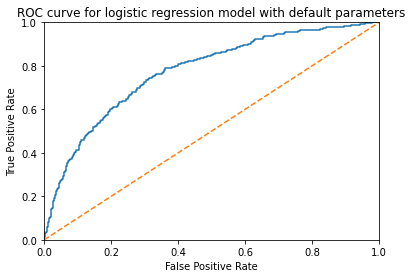

In [25]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_d)
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve for logistic regression model with default parameters")
plt.show()

As expected, the metrics are low. There is no point in looking at the accuracy score, because the classes are not balanced. The metrics for the logistic regression model are higher than for the random forest. The F1 metric is 9% for logistic regression and 55% for random forest. The area under the error curve is 65%.

### Working with unbalanced classes  <a id="optimization"></a>

[Back to content](#content)

#### Hyper-parameter class_weight='balanced' <a id="balanced"></a> 

Let's select the depth and number of trees for the random forest model and specify the hyper-parameter class_weight= 'balanced'.

In [26]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 100, 5):
    for depth in range (1, 16, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train) 
        rf_predictions = model.predict(features_valid)
        result = f1_score(target_valid, rf_predictions)
        if result > best_result:
            best_model = model 
            best_result = result.round(3)
            best_est = est
            best_depth = depth
            
print("F1 score of the best model for random forest on the validation set is", best_result, "Number of estimators", best_est, "Max depth:", depth)

F1 score of the best model for random forest on the validation set is 0.636 Number of estimators 90 Max depth: 15
Wall time: 1min 55s


We could increase the F1 score of the random forest model on the validation sample from 53% to 63.5% with hyper-parameters: depth- 15, number of estimators - 75, class_weight= 'balanced'. Time ~ 1min 40s.

Now let's look at the logistic regression model with the class_weight='balanced' parameter. Let's check the metrics with different thresholds.

In [27]:
lr_model_b = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')
lr_model_b.fit(features_train, target_train)
probabilities_valid_b = lr_model_b.predict_proba(features_valid)
probabilities_one_valid_b = probabilities_valid_b[:, 1]

In [28]:
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid_b > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Precision = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.10 | Precision = 0.208, Recall = 1.000, F1 = 0.344
Threshold = 0.15 | Precision = 0.216, Recall = 0.985, F1 = 0.355
Threshold = 0.20 | Precision = 0.231, Recall = 0.971, F1 = 0.373
Threshold = 0.25 | Precision = 0.252, Recall = 0.953, F1 = 0.399
Threshold = 0.30 | Precision = 0.276, Recall = 0.922, F1 = 0.424
Threshold = 0.35 | Precision = 0.300, Recall = 0.865, F1 = 0.445
Threshold = 0.40 | Precision = 0.333, Recall = 0.831, F1 = 0.475
Threshold = 0.45 | Precision = 0.362, Recall = 0.770, F1 = 0.493
Threshold = 0.50 | Precision = 0.392, Recall = 0.703, F1 = 0.504
Threshold = 0.55 | Precision = 0.423, Recall = 0.635, F1 = 0.508
Threshold = 0.60 | Precision = 0.464, Recall = 0.551, F1 = 0.504
Threshold = 0.65 | Precision = 0.513, Recall = 0.471, F1 = 0.491
Threshold = 0.70 | Precision = 0.545, Recall = 0.370, F1 = 0.441
Threshold = 0.75 | Precis

The F1 score was the highest at the 0.55 threshold, but still quite low - at 50%. Let's look at the error curve.

In [29]:
auc_roc_b=roc_auc_score(target_valid, probabilities_one_valid_b)
print(auc_roc_b)

0.7789468174204355


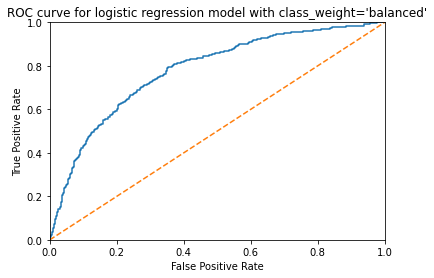

In [30]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_b)
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve for logistic regression model with class_weight='balanced'")
plt.show()

Auc_roc is 77%.

#### Upsampling <a id="upsampling"></a>

[Back to content](#content)

Let's look at the result after leveling the class sizes: increasing the positive class to negative and reducing the negative class to positive.

First, let's increase: we know that the class ratio of 0:1 is the same as 80:20, so we increase the positive class by 4 times.

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Let's look at the results on the random forest model.

In [32]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 100, 5):
    for depth in range (1, 16, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled) 
        rf_predictions = model.predict(features_valid)
        result = f1_score(target_valid, rf_predictions)
        if result > best_result:
            best_model = model 
            best_result = result
            best_est = est
            best_depth = depth
            
print("F1 score of the best model for random forest on the validation set is", best_result, "Number of estimators", best_est, "Max depth:", depth)

F1 score of the best model for random forest on the validation set is 0.6407766990291263 Number of estimators 45 Max depth: 15
Wall time: 2min 40s


The F1 score of the random forest model on the enlarged sample is ~64%, number of estimators: 45, max depth: 15.
Time ~2min.

Let's look at the results of the logistic regression model.

In [33]:
lr_model_up=LogisticRegression(solver='liblinear', random_state=0)
lr_model_up.fit(features_upsampled, target_upsampled)
predicted_valid_up=lr_model_up.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_up))

F1: 0.5056669572798606


With the increase of the positive class, the F1 score of the logistic regression model reached only 50%.

In [34]:
probabilities_valid_up = lr_model_up.predict_proba(features_valid)
probabilities_one_valid_up = probabilities_valid_up[:, 1]
auc_roc_up=roc_auc_score(target_valid, probabilities_one_valid_up)
print(auc_roc_d)

0.774422048970342


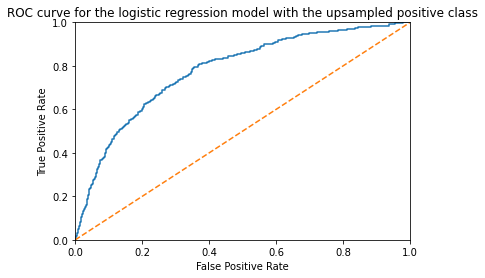

In [35]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_up)
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve for the logistic regression model with the upsampled positive class")
plt.show()

The area under the error curve is 65%.

### Downsampling

Let's take only one-fourth of the zero class.

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Let's look at the results on the random forest model.

In [37]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 100, 5):
    for depth in range (1, 16, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled) 
        rf_predictions = model.predict(features_valid)
        result = f1_score(target_valid, rf_predictions)
        if result > best_result:
            best_model = model 
            best_result = result
            best_est = est
            best_depth = depth
            
print("F1 score of the best model for random forest on the validation set is", best_result, "Number of estimators", best_est, "Max depth:", depth)

F1 score of the best model for random forest on the validation set is 0.6205493387589014 Number of estimators 90 Max depth: 15
Wall time: 50.8 s


With the reduced sample of class zero, it was possible to achieve 62% of the F1 score on the random forest model. Number of estimators 90, xax depth: 15. Time ~1min. 

In [38]:
lr_model_down=LogisticRegression(solver='liblinear', random_state=0)
lr_model_down.fit(features_downsampled, target_downsampled)
predicted_valid_down=lr_model_down.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_down))

F1: 0.5061728395061729


The F1 score outputs 50% on the logistic regression model trained on a reduced sample.

In [39]:
probabilities_valid_down = lr_model_down.predict_proba(features_valid)
probabilities_one_valid_down = probabilities_valid_down[:, 1]
auc_roc_down=roc_auc_score(target_valid, probabilities_one_valid_down)
print(auc_roc_down)

0.7794240811902651


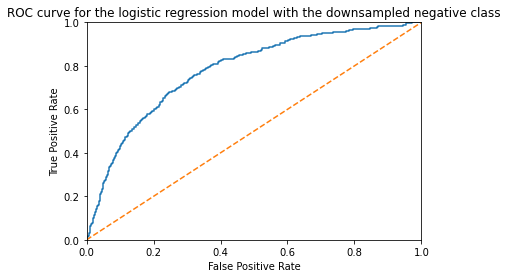

In [40]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_down)
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve for the logistic regression model with the downsampled negative class")
plt.show()

The area under the error curve is 78%.

To sum up, the best F1 score result on the validation sample shows the random forest model trained on a set with an increased positive class with parameters: number of estmators: 45, max depth: 15

## Optimal model on the test sample <a id="test"></a>

[Back to content](#content)

We will conduct the final testing with the random forest model on a sample where the positive class is increased to the zero class, and we will set the hyper parameters n_estimators=45, max_depth=15.

In [41]:
rf_model_final = RandomForestClassifier(random_state=12345, n_estimators=45, max_depth=15)
rf_model_final.fit(features_upsampled, target_upsampled) 
rf_predictions_final = rf_model_final.predict(features_test)
f1_final = (f1_score(target_test, rf_predictions_final)).round(2)
f1_final

0.59

We reached 59% for the F1 measure.

## Summary <a id="summary"></a>

[Back to content](#content)

- The churn is most noticeably influenced by the age and activity of the client. 
- The credit score is higher for those who stay, the difference in peak values is 10 points.
- We see that the departed are older, the peak frequency is 45 years old, for the remaining - 37.
- The balance on the card of the churn customer is greater than that of the remaining.
- Among the remaining customers, two products are more often used than among those who left.
- Among customers from Germany, the percentage of churn customers is higher than in France and Spain.
- There is a lower outflow rate among credit card users.
- The percentage of those who left is higher among women.
- The percentage of churn is higher among inactive users.

Since the classes are not balanced, the optimal prediction model is the random forest model trained on a set with an increased positive class with parameters: number of estmators: 45, max depth: 15